# Segmentasi Area Banjir Menggunakan Deep Learning

Proyek ini berfokus pada **deteksi dan segmentasi area banjir otomatis** dari gambar menggunakan **segmentasi semantik berbasis deep learning**. Proyek ini terinspirasi dari bencana banjir yang melanda Aceh, Sumatera Utara, dan Sumatera Barat. Model dilatih untuk mengidentifikasi dan membatasi wilayah banjir pada tingkat piksel, sehingga memungkinkan pemetaan dan analisis banjir yang akurat.

## Fitur Utama
- Segmentasi semantik biner (Banjir vs. Tidak Banjir)
- Arsitektur encoder-decoder dengan **backbone ImageNet yang telah dilatih sebelumnya**
- Kombinasi **Dice Loss dan Binary Cross-Entropy Loss** untuk menangani ketidakseimbangan kelas
- Evaluasi menggunakan **IoU, Akurasi, Presisi, Recall, dan F1-score**
- **Penghentian dini** untuk mencegah overfitting
- Visualisasi area banjir yang diprediksi dengan masker overlay
- Dukungan inferensi untuk gambar yang belum pernah dilihat sebelumnya

## Sumber Dataset
Dataset yang digunakan bersumber dari platform Kaggle yang diunduh melalui tautan berikut ini: [Flood Area Segmentation](https://www.kaggle.com/datasets/faizalkarim/flood-area-segmentation)

## Teknologi
- Python, PyTorch
- segmentation-models-pytorch
- OpenCV, Albumentations, Matplotlib

Proyek ini menyediakan **dasar yang kuat dan terukur** untuk tugas segmentasi banjir dan dapat diperluas untuk analisis video, data geospasial, atau aplikasi real-time.

## Import Library

Bagian ini berisi kumpulan library yang digunakan untuk **pemrosesan data, pelatihan model deep learning, dan visualisasi hasil**.

In [207]:
import os
import re
import cv2
import shutil
import random
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

## Pembagian Dataset (Train & Validation)

Bagian ini digunakan untuk **menyiapkan dan membagi dataset gambar dan mask** ke dalam data **training** dan **validation** secara otomatis. Tujuannya memastikan **data training dan validation tersusun rapi, seimbang, dan sinkron** antara gambar dan mask sebelum proses pelatihan model segmentasi.

In [195]:
RAW_PATH = "data/images"
MASK_PATH = "data/masks"
TRAIN_RAW_PATH = "train/images"
TRAIN_MASK_PATH = "train/masks"
VAL_RAW_PATH = "val/images"
VAL_MASK_PATH = "val/masks"

def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r"(\d+)", s)]

raw_images = sorted(os.listdir(RAW_PATH))
raw_images.sort(key = natural_sort_key)
random.shuffle(raw_images)

val_count = int(len(raw_images) * 0.2)

for dirname in [TRAIN_RAW_PATH, TRAIN_MASK_PATH, VAL_RAW_PATH, VAL_MASK_PATH]:
    for file in glob.glob(os.path.join(dirname, "*")):
        os.remove(file)

for [index, img] in enumerate(raw_images):
    base_img = img.split(".")[0]
    raw_img_path = base_img + ".jpg"
    mask_img_path = base_img + ".png"
    
    if index < val_count:
        shutil.copy(os.path.join(RAW_PATH, raw_img_path), os.path.join(VAL_RAW_PATH, raw_img_path))
        shutil.copy(os.path.join(MASK_PATH, mask_img_path), os.path.join(VAL_MASK_PATH, mask_img_path))
    else:
        shutil.copy(os.path.join(RAW_PATH, raw_img_path), os.path.join(TRAIN_RAW_PATH, raw_img_path))
        shutil.copy(os.path.join(MASK_PATH, mask_img_path), os.path.join(TRAIN_MASK_PATH, mask_img_path))

## Pengelompokan Path Dataset

Bagian ini bertujuan untuk **mengumpulkan dan mengorganisir path file gambar dan mask** untuk dataset training dan validasi.

In [196]:
IMAGE_PATHS = {
    "train": {
        "images": [],
        "masks": []
    },
    "val": {
        "images": [],
        "masks": []
    }
}

def assign_paths(image_paths, source_path):
    for image_path in sorted(os.listdir(source_path)):
        image_paths.append(os.path.join(source_path, image_path))

    image_paths.sort(key = natural_sort_key)

assign_paths(IMAGE_PATHS["train"]["images"], TRAIN_RAW_PATH)
assign_paths(IMAGE_PATHS["train"]["masks"], TRAIN_MASK_PATH)
assign_paths(IMAGE_PATHS["val"]["images"], VAL_RAW_PATH)
assign_paths(IMAGE_PATHS["val"]["masks"], VAL_MASK_PATH)

## Pembersihan Data Gambar Rusak

Bagian ini digunakan untuk **menyaring dan menghapus data gambar atau mask yang bermasalah** sebelum digunakan dalam proses training.

In [197]:
def remove_broken_images(image_path, mask_path):
    temp_paths = {
        "images": [],
        "masks": []
    }

    for img_p, mask_p in tqdm(zip(image_path, mask_path)):
        img = cv2.imread(str(img_p))
        mask = cv2.imread(str(mask_p), cv2.IMREAD_GRAYSCALE)

        if img is None or mask is None:
            continue

        if img.shape[:2] != mask.shape[:2]:
            continue

        temp_paths["images"].append(img_p)
        temp_paths["masks"].append(mask_p)
    
    return temp_paths

IMAGE_PATHS["train"] = remove_broken_images(IMAGE_PATHS["train"]["images"], IMAGE_PATHS["train"]["masks"])
IMAGE_PATHS["val"] = remove_broken_images(IMAGE_PATHS["val"]["images"], IMAGE_PATHS["val"]["masks"])

232it [00:03, 59.68it/s] 
58it [00:00, 65.25it/s]


## Kelas FloodDataset

Bagian ini mendefinisikan **custom dataset PyTorch** untuk tugas segmentasi banjir. Dataset ini nantinya digunakan oleh **DataLoader** untuk mempermudah proses training dan validasi model segmentasi.

In [198]:
class FloodDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform = None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = str(self.image_paths[idx])
        mask_path  = str(self.mask_paths[idx])

        images = cv2.imread(image_path)
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)

        masks = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        masks = (masks > 0).astype("float32")

        if self.transform:
            augmented = self.transform(image = images, mask = masks)
            images = augmented["image"]
            masks = augmented["mask"]

        images = torch.tensor(images).permute(2, 0, 1).float()
        masks = torch.tensor(masks).unsqueeze(0)

        return images, masks

## Transformasi Data (Augmentasi & Normalisasi)

Bagian ini mendefinisikan **pipeline transformasi** menggunakan *Albumentations* untuk data training dan validasi. Pendekatan ini memastikan model belajar dari data yang bervariasi saat training dan dievaluasi secara adil saat validasi.

In [199]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p = 0.5),
    A.VerticalFlip(p = 0.3),
    A.RandomBrightnessContrast(p = 0.3),
    A.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225)),
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225)),
])

## Dataset dan DataLoader

Bagian ini digunakan untuk **menyiapkan dataset dan DataLoader** yang akan digunakan pada proses training dan validasi model. Dengan konfigurasi ini, proses training menjadi lebih efisien dan evaluasi model dapat dilakukan secara stabil.

In [200]:
train_dataset = FloodDataset(
    IMAGE_PATHS["train"]["images"],
    IMAGE_PATHS["train"]["masks"],
    transform = train_transform
)

val_dataset = FloodDataset(
    IMAGE_PATHS["val"]["images"],
    IMAGE_PATHS["val"]["masks"],
    transform = val_transform
)

train_loader = DataLoader(train_dataset, batch_size = 8, shuffle = True, num_workers = 4)
val_loader = DataLoader(val_dataset, batch_size = 8, shuffle = False, num_workers = 4)

## Kelas EarlyStopping

Bagian ini mengimplementasikan **Early Stopping**, yaitu mekanisme untuk menghentikan proses training secara otomatis ketika performa model tidak lagi mengalami peningkatan. Early Stopping membantu **mencegah overfitting** dan menghemat waktu training.

In [201]:
class EarlyStopping:
    def __init__(self, patience = 5, min_delta = 1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best_score = None
        self.counter = 0
        self.stop = False

    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            print(f"EarlyStopping counter {self.counter}/{self.patience}")

            if self.counter >= self.patience:
                self.stop = True
        else:
            self.best_score = score
            self.counter = 0

## Kelas TrainModel

Bagian ini mendefinisikan kelas **TrainModel** yang mengelola seluruh proses training dan validasi model segmentasi banjir secara terstruktur. Kelas ini memastikan proses training berjalan efisien, terukur, dan terhindar dari overfitting.

In [202]:
class TrainModel:
    def __init__(self, epochs, best_iou, early_stopping_patience, loss_fn, optimizer, model, device, model_path):
        self._epochs = epochs
        self._best_iou = best_iou
        self._early_stopping = EarlyStopping(patience = early_stopping_patience)
        self._loss_fn = loss_fn
        self._optimizer = optimizer
        self._device = device
        self._model = model
        self._model_path = model_path

    def _pixel_accuracy(self, preds, masks, threshold = 0.5):
        preds = torch.sigmoid(preds)
        preds = (preds > threshold).float()
        correct = (preds == masks).float().sum()
        total = masks.numel()

        return correct / total

    def _train_one_epoch(self, loader):
        self._model.train()
        total_loss = 0
        total_acc = 0

        for images, masks in tqdm(loader):
            images, masks = images.to(self._device), masks.to(self._device)
            preds = self._model(images)
            loss = self._loss_fn(preds, masks)
            acc = self._pixel_accuracy(preds, masks)

            self._optimizer.zero_grad()
            loss.backward()
            self._optimizer.step()
            
            total_loss += loss.item()
            total_acc += acc.item()

        return (total_loss / len(loader), total_acc / len(loader))
    
    def _segmentation_metrics(self, preds, masks, threshold = 0.5, eps = 1e-7):
        preds = torch.sigmoid(preds)
        preds = (preds > threshold).float()
        tp = (preds * masks).sum()
        tn = ((1 - preds) * (1 - masks)).sum()
        fp = (preds * (1 - masks)).sum()
        fn = ((1 - preds) * masks).sum()
        accuracy = (tp + tn) / (tp + tn + fp + fn + eps)
        precision = tp / (tp + fp + eps)
        recall = tp / (tp + fn + eps)
        f1 = 2 * precision * recall / (precision + recall + eps)

        return accuracy, precision, recall, f1
    
    def _iou_score(self, preds, masks, threshold = 0.5):
        preds = torch.sigmoid(preds)
        preds = (preds > threshold).float()
        intersection = (preds * masks).sum()
        union = preds.sum() + masks.sum() - intersection

        return (intersection + 1e-6) / (union + 1e-6)

    def _validate(self, loader):
        if len(loader) == 0:
            return 0, 0, 0, 0, 0, 0

        self._model.eval()
        total_loss = 0
        total_iou = 0
        total_acc = 0
        total_prec = 0
        total_rec = 0
        total_f1 = 0

        with torch.no_grad():
            for images, masks in loader:
                images, masks = images.to(self._device), masks.to(self._device)
                preds = self._model(images)
                loss = self._loss_fn(preds, masks)
                iou = self._iou_score(preds, masks)
                acc, prec, rec, f1 = self._segmentation_metrics(preds, masks)

                total_loss += loss.item()
                total_iou += iou.item()
                total_acc += acc.item()
                total_prec += prec.item()
                total_rec += rec.item()
                total_f1 += f1.item()

        n = len(loader)

        return (total_loss / n, total_iou / n, total_acc / n, total_prec / n, total_rec / n, total_f1 / n)

    def train(self):
        for epoch in range(self._epochs):
            train_loss, train_acc = self._train_one_epoch(train_loader)
            (val_loss, val_iou, val_acc, val_prec, val_rec, val_f1) = self._validate(val_loader)

            print(f"\nEpoch [{epoch + 1}/{self._epochs}]")
            print(f"Train Loss : {train_loss:.4f}")
            print(f"Train Acc  : {train_acc:.4f}")
            print(f"Val Loss   : {val_loss:.4f}")
            print(f"Val IoU    : {val_iou:.4f}")
            print(f"Val Acc    : {val_acc:.4f}")
            print(f"Val Prec   : {val_prec:.4f}")
            print(f"Val Recall : {val_rec:.4f}")
            print(f"Val F1     : {val_f1:.4f}")

            if val_iou > self._best_iou:
                self._best_iou = val_iou
                torch.save(self._model.state_dict(), self._model_path)
                print(f"_Model saved to {self._model_path}")

            self._early_stopping(val_iou)

            if self._early_stopping.stop:
                print("Early stopping triggered")
                break

## Inisialisasi Device dan Model

Bagian ini digunakan untuk menentukan **perangkat komputasi** dan **arsitektur model segmentasi** yang akan digunakan.

In [203]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = smp.Unet(
    encoder_name = "resnet34",
    encoder_weights = "imagenet",
    in_channels = 3,
    classes = 1
)

model.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

## Konfigurasi Loss Function, Optimizer, dan Training

Bagian ini mengatur **fungsi loss**, **optimizer**, serta proses **pelatihan model**.

In [ ]:
LEARNING_RATE = 1e-4
EPOCHS = 30
BEST_IOU = 0

dice_loss = smp.losses.DiceLoss(mode = "binary")
bce_loss = nn.BCEWithLogitsLoss()

def loss_fn(preds, masks):
    return dice_loss(preds, masks) + bce_loss(preds, masks)

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

train_model = TrainModel(EPOCHS, BEST_IOU, 5, loss_fn, optimizer, model, device, "model/best_flood_segmentation.pth")
train_model.train()

100%|██████████| 29/29 [00:48<00:00,  1.69s/it]



Epoch [1/30]
Train Loss : 0.9963
Train Acc  : 0.6935
Val Loss   : 0.8150
Val IoU    : 0.6268
Val Acc    : 0.8017
Val Prec   : 0.6950
Val Recall : 0.8632
Val F1     : 0.7689
_Model saved to best_flood_segmentation.pth


100%|██████████| 29/29 [00:48<00:00,  1.68s/it]



Epoch [2/30]
Train Loss : 0.7065
Train Acc  : 0.8261
Val Loss   : 0.6443
Val IoU    : 0.7025
Val Acc    : 0.8561
Val Prec   : 0.7752
Val Recall : 0.8826
Val F1     : 0.8231
_Model saved to best_flood_segmentation.pth


100%|██████████| 29/29 [00:49<00:00,  1.69s/it]



Epoch [3/30]
Train Loss : 0.5703
Train Acc  : 0.8727
Val Loss   : 0.5305
Val IoU    : 0.7542
Val Acc    : 0.8877
Val Prec   : 0.8231
Val Recall : 0.8987
Val F1     : 0.8584
_Model saved to best_flood_segmentation.pth


100%|██████████| 29/29 [00:49<00:00,  1.69s/it]



Epoch [4/30]
Train Loss : 0.5083
Train Acc  : 0.8892
Val Loss   : 0.4780
Val IoU    : 0.7675
Val Acc    : 0.8967
Val Prec   : 0.8488
Val Recall : 0.8885
Val F1     : 0.8671
_Model saved to best_flood_segmentation.pth


100%|██████████| 29/29 [00:48<00:00,  1.68s/it]



Epoch [5/30]
Train Loss : 0.4627
Train Acc  : 0.8968
Val Loss   : 0.4493
Val IoU    : 0.7761
Val Acc    : 0.9031
Val Prec   : 0.8662
Val Recall : 0.8826
Val F1     : 0.8730
_Model saved to best_flood_segmentation.pth


100%|██████████| 29/29 [00:48<00:00,  1.68s/it]



Epoch [6/30]
Train Loss : 0.4328
Train Acc  : 0.9056
Val Loss   : 0.4118
Val IoU    : 0.7904
Val Acc    : 0.9107
Val Prec   : 0.8910
Val Recall : 0.8759
Val F1     : 0.8820
_Model saved to best_flood_segmentation.pth


100%|██████████| 29/29 [00:49<00:00,  1.69s/it]



Epoch [7/30]
Train Loss : 0.4029
Train Acc  : 0.9109
Val Loss   : 0.4135
Val IoU    : 0.7921
Val Acc    : 0.9096
Val Prec   : 0.8708
Val Recall : 0.8977
Val F1     : 0.8829
_Model saved to best_flood_segmentation.pth


100%|██████████| 29/29 [00:48<00:00,  1.68s/it]



Epoch [8/30]
Train Loss : 0.4038
Train Acc  : 0.9091
Val Loss   : 0.4126
Val IoU    : 0.7876
Val Acc    : 0.9105
Val Prec   : 0.8917
Val Recall : 0.8721
Val F1     : 0.8801
EarlyStopping counter 1/5


100%|██████████| 29/29 [00:48<00:00,  1.68s/it]



Epoch [9/30]
Train Loss : 0.3713
Train Acc  : 0.9176
Val Loss   : 0.3947
Val IoU    : 0.7903
Val Acc    : 0.9132
Val Prec   : 0.9095
Val Recall : 0.8579
Val F1     : 0.8820
EarlyStopping counter 2/5


100%|██████████| 29/29 [00:47<00:00,  1.65s/it]



Epoch [10/30]
Train Loss : 0.3730
Train Acc  : 0.9157
Val Loss   : 0.3898
Val IoU    : 0.7950
Val Acc    : 0.9126
Val Prec   : 0.8833
Val Recall : 0.8888
Val F1     : 0.8849
_Model saved to best_flood_segmentation.pth


100%|██████████| 29/29 [00:48<00:00,  1.66s/it]



Epoch [11/30]
Train Loss : 0.3549
Train Acc  : 0.9198
Val Loss   : 0.4132
Val IoU    : 0.7895
Val Acc    : 0.9053
Val Prec   : 0.8426
Val Recall : 0.9265
Val F1     : 0.8814
EarlyStopping counter 1/5


100%|██████████| 29/29 [00:48<00:00,  1.68s/it]



Epoch [12/30]
Train Loss : 0.3510
Train Acc  : 0.9205
Val Loss   : 0.3815
Val IoU    : 0.7981
Val Acc    : 0.9162
Val Prec   : 0.9085
Val Recall : 0.8693
Val F1     : 0.8869
_Model saved to best_flood_segmentation.pth


100%|██████████| 29/29 [00:48<00:00,  1.67s/it]



Epoch [13/30]
Train Loss : 0.3455
Train Acc  : 0.9204
Val Loss   : 0.3686
Val IoU    : 0.8005
Val Acc    : 0.9172
Val Prec   : 0.9044
Val Recall : 0.8753
Val F1     : 0.8884
_Model saved to best_flood_segmentation.pth


100%|██████████| 29/29 [00:49<00:00,  1.70s/it]



Epoch [14/30]
Train Loss : 0.3382
Train Acc  : 0.9229
Val Loss   : 0.3743
Val IoU    : 0.8010
Val Acc    : 0.9166
Val Prec   : 0.9020
Val Recall : 0.8793
Val F1     : 0.8887
_Model saved to best_flood_segmentation.pth


100%|██████████| 29/29 [00:48<00:00,  1.68s/it]



Epoch [15/30]
Train Loss : 0.3204
Train Acc  : 0.9269
Val Loss   : 0.3681
Val IoU    : 0.7994
Val Acc    : 0.9179
Val Prec   : 0.9209
Val Recall : 0.8595
Val F1     : 0.8878
EarlyStopping counter 1/5


100%|██████████| 29/29 [00:49<00:00,  1.69s/it]



Epoch [16/30]
Train Loss : 0.3074
Train Acc  : 0.9300
Val Loss   : 0.3551
Val IoU    : 0.8079
Val Acc    : 0.9205
Val Prec   : 0.9151
Val Recall : 0.8755
Val F1     : 0.8932
_Model saved to best_flood_segmentation.pth


100%|██████████| 29/29 [00:49<00:00,  1.69s/it]



Epoch [17/30]
Train Loss : 0.3068
Train Acc  : 0.9292
Val Loss   : 0.3603
Val IoU    : 0.8008
Val Acc    : 0.9183
Val Prec   : 0.9146
Val Recall : 0.8666
Val F1     : 0.8886
EarlyStopping counter 1/5


100%|██████████| 29/29 [00:49<00:00,  1.70s/it]



Epoch [18/30]
Train Loss : 0.2984
Train Acc  : 0.9313
Val Loss   : 0.3610
Val IoU    : 0.8049
Val Acc    : 0.9177
Val Prec   : 0.8937
Val Recall : 0.8913
Val F1     : 0.8912
EarlyStopping counter 2/5


100%|██████████| 29/29 [00:49<00:00,  1.70s/it]



Epoch [19/30]
Train Loss : 0.3037
Train Acc  : 0.9312
Val Loss   : 0.3669
Val IoU    : 0.8053
Val Acc    : 0.9161
Val Prec   : 0.8828
Val Recall : 0.9037
Val F1     : 0.8916
EarlyStopping counter 3/5


100%|██████████| 29/29 [00:49<00:00,  1.70s/it]



Epoch [20/30]
Train Loss : 0.2803
Train Acc  : 0.9361
Val Loss   : 0.3615
Val IoU    : 0.8023
Val Acc    : 0.9177
Val Prec   : 0.9077
Val Recall : 0.8752
Val F1     : 0.8896
EarlyStopping counter 4/5


100%|██████████| 29/29 [00:49<00:00,  1.70s/it]



Epoch [21/30]
Train Loss : 0.2871
Train Acc  : 0.9334
Val Loss   : 0.3603
Val IoU    : 0.8062
Val Acc    : 0.9175
Val Prec   : 0.8877
Val Recall : 0.8989
Val F1     : 0.8921
EarlyStopping counter 5/5
Early stopping triggered


## Kelas TestModel

Bagian ini mendefinisikan class **TestModel** yang digunakan untuk melakukan **inferensi (prediksi)** pada gambar baru dan menampilkan hasil segmentasi banjir.

In [ ]:
class TestModel:
    def __init__(self, image_size = 256):
        self.image_size = image_size
        self.infer_transform = A.Compose([
            A.Resize(self.image_size, self.image_size),
            A.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225)),
            ToTensorV2(),
        ])

    def _overlay_mask(self, image, mask, alpha = 0.5, color = (255, 0, 0)):
        overlay = image.copy()
        mask = mask.astype(bool)
        overlay[mask] = color

        return cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)
    
    def infer_flood_image(self, image_path, model, device, threshold = 0.5, show = True, save_dir = None):
        image_bgr = cv2.imread(image_path)

        if image_bgr is None:
            raise ValueError(f"Image not found: {image_path}")

        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        transformed = self.infer_transform(image = image_rgb)
        input_tensor = transformed["image"].unsqueeze(0).to(device)

        model.eval()

        with torch.no_grad():
            preds = model(input_tensor)
            preds = torch.sigmoid(preds)
            mask = (preds > threshold).float()

        mask = mask.squeeze().cpu().numpy()
        mask = cv2.resize(mask, (image_bgr.shape[1], image_bgr.shape[0]))
        mask = (mask > 0.5).astype(np.uint8)
        overlay = self._overlay_mask(image_rgb, mask)

        if save_dir:
            os.makedirs(save_dir, exist_ok = True)
            
            cv2.imwrite(os.path.join(save_dir, "original.png"), cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR))
            cv2.imwrite(os.path.join(save_dir, "mask.png"), mask * 255)
            cv2.imwrite(os.path.join(save_dir, "overlay.png"), cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
        
        if show:
            fig, axs = plt.subplots(1, 3, figsize = (18, 6))

            axs[0].imshow(image_rgb)
            axs[0].set_title("Original Image")
            axs[0].axis("off")

            axs[1].imshow(mask, cmap = "gray")
            axs[1].set_title("Predicted Flood Mask")
            axs[1].axis("off")

            axs[2].imshow(overlay)
            axs[2].set_title("Flood Segmentation Overlay")
            axs[2].axis("off")

            plt.tight_layout()
            plt.show()

        return overlay, mask

## Pengujian Model pada Gambar Baru

Bagian ini digunakan untuk **memuat model terbaik** dan melakukan **inferensi segmentasi banjir** pada gambar uji. Output divisualisasikan menggunakan Matplotlib dalam satu frame yang berisi gambar asli, mask prediksi, dan overlay segmentasi banjir.

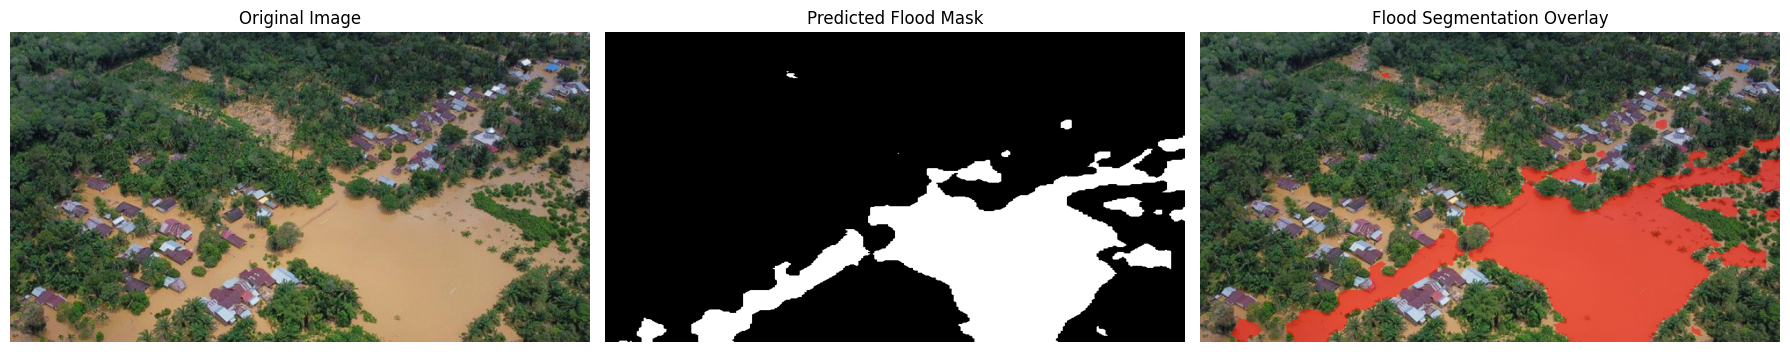

In [228]:
test_model = TestModel(256)

model.load_state_dict(torch.load("model/best_flood_segmentation.pth", map_location = device))
model.to(device)

overlay, mask = test_model.infer_flood_image(
    image_path = "test/image.png",
    model = model,
    device = device,
    threshold = 0.5,
    save_dir = "result"
)

## Hasil Prediksi

Tabel di bawah ini menunjukkan gambar-gambar hasil prediksi yang terdiri dari gambar original, mask, dan overlay.

<table>
    <thead>
        <td align="center">
            <strong>Original Image</strong>
        </td>
        <td align="center">
            <strong>Predicted Flood Mask</strong>
        </td>
        <td align="center">
            <strong>Flood Segmentation Overlay</strong>
        </td>
    </thead>
    <tbody>
        <tr>
            <td>
                <img src="result/original.png" width="360px" alt="Original Image"></img>
            </td>
            <td>
                <img src="result/mask.png" width="360px" alt="Predicted Flood Mask"></img>
            </td>
            <td>
                <img src="result/overlay.png" width="360px" alt="Flood Segmentation Overlay"></img>
            </td>
        </tr>
    </tbody>
</table>

Visualisasi hasil prediksi menunjukkan bahwa model mampu mengenali dan melakukan segmentasi area banjir dengan sangat baik pada gambar yang digunakan sebagai data pengujian.